## Statistics for Data Science and Robotics, Assignment 1
by Domrachev Ivan, B20-Ro-01

**Task Description** 
> Citizent of city I has recently complained about the quality of the central water supply. The main complains are a strong odor of chlorine and skin itching. Being a responsible person, highly respected Mayor of the city I invited a water quality control service to confirm the high concentration of chlorine in the water. Out of collected $n = 57$ samples, $x = 11$ had a concentration of Chlorine above the governmental standards. Let $\theta$ denote a true probability that the concentration of Chlorine in a sample exceeds the governmental threshold.


In [1]:
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt

## Task 1

> What is the conditional distribution of X, the number of samples having a Chlorine concentration above the threshold, given θ?

Since the water could have either excessive or normal Chlorine concentration, we are dealing with *binomial distribution*:
$$X = B(n, \theta),$$
and the probability that out of 57 samples we got 11 excessive ones is:
$$P(X=x) = \left( \begin{aligned} n \\ x \end{aligned}\right) \theta^x (1-\theta)^(n-x)$$

## Task 2

> Before the experiment, the control service experts elicited that the expected value of $\theta$ is $0.2$ with a standard deviation of $0.16$. Determine the parameters $\alpha$ and $\beta$ of a Beta prior distribution for $\theta$ with this prior mean and standard deviation. (Round $\alpha$ and $\beta$ to the nearest integer).

To avoid numerical integration, it would be nice to deal with continuous distribution, but with similar properties to discrete binomial distribution. Such distributions in context of Bayesian statistics are called [Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior).

For the binomial distribution, the conjugate prior is Beta distribution:
$$p(\theta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{\Beta_f(\alpha, \beta)},$$
where $\Beta_f(\alpha, \beta)$ is a [Beta function](https://en.wikipedia.org/wiki/Beta_function).

Given the distribution, the mean and variance are:
$$E[B] = \frac{\alpha}{\alpha + \beta}$$
$$Var[B] = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$$

By solving this sytem of equations w.r.t. $\alpha$ and $\beta$, we get:
$$\alpha= \mu \left(\frac{\mu(1-\mu)}{\text{var}}-1\right)$$
$$\beta = (1 - \mu)\left(\frac{\mu(1-\mu)}{\text{var}}-1\right),$$
if $\text{var}< \mu(1-\mu)$.

In [2]:
mu = 0.2
var = 0.16 ** 2

# First, check the condition
assert var < mu * (1-mu)

# Now, proceed with calculating alpha and beta
alpha1 = mu * (mu * (1-mu) / var - 1)
beta1 = (1-mu) * (mu * (1-mu) / var - 1)

print(alpha1, beta1)

# Finally, round the hyperparameters
alpha1 = int(alpha1)
beta1 = int(beta1)

print(alpha1, beta1)

1.0500000000000003 4.200000000000001
1 4


## Task 3

> Find the posterior distribution of $\theta$ and summarize it by its posterior mean and standard deviation.

Now, to find the posterior distribution, let's calculate:
  1. Likelihood $P(x,n | q=\theta$, which we have already calculated in task 1.
  2. Prior probability $P(q=\theta)$, which we have already calculated in the task 2.
  3. Normalizing term $P(q=\theta \mid x,n)$.

$$\begin{aligned}
  P(x, n \mid q=\theta) &= {n \choose x} \theta^x(1-\theta)^{n-x},\\
              P(q=\theta) &= {\theta^{\alpha-1}(1-\theta)^{\beta-1} \over \Beta(\alpha,\beta)},\\
   P(q=\theta \mid x,n) &= \frac{P(x, n \mid \theta)P(\theta)}{\int_{-\infty}^\infty P(x, n \mid \tilde{\theta})P(\tilde{\theta})d\tilde{\theta}}\\
                   & = {{{n \choose x} \theta^{x+\alpha-1}(1-\theta)^{n-x+\beta-1} / \Beta(\alpha,\beta)} \over \int_{\tilde{\theta}=0}^1 \left({n \choose x} y^{x+\alpha-1}(1-\tilde{\theta})^{f+\beta-1} / \Beta(\alpha,\beta)\right) d\tilde{\theta}} \\
                   & = {\theta^{x+\alpha-1}(1-\theta)^{n-x+\beta-1} \over \Beta_f(x+\alpha,n-x+\beta)} = \Beta(\alpha + x, \beta + n - x),
\end{aligned}$$
where $\Beta_f$ is a Beta function (not distribution)

As such, the resulting distribution is also a Beta distribution with different hyperparameters $\alpha, \beta$. The mean and variance are calculated as before.

In [3]:
n = 57
x = 11

# Calculating new alpha and beta hyperparameters for posterior probability
alpha2 = alpha1 + x
beta2 = beta1 + n - x

# Now, their mean and variance could be calculated as follows
mu2 = alpha2 / (alpha2 + beta2)
std2 = np.sqrt((alpha2 * beta2) / ((alpha2 + beta2)**2 * (alpha2 + beta2 + 1)))

print(f"Posterior distribution is X_post = Beta({alpha2}, {beta2}), E[X_post] = {mu2}, Std[X_post] = {std2}")

Posterior distribution is X_post = Beta(12, 50), E[X_post] = 0.1935483870967742, Std[X_post] = 0.04977527418131997


## Task 4

> Plot the prior, posterior and normalized likelihood.

Let's do it!

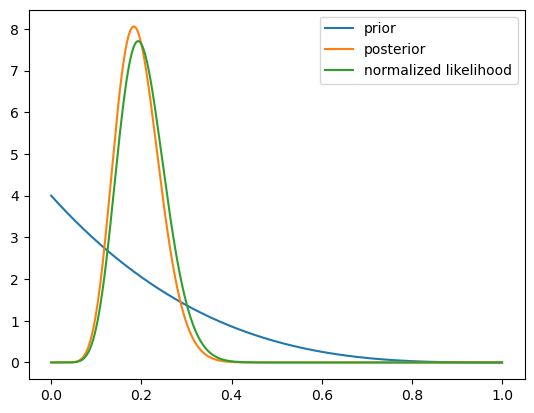

In [4]:
from sklearn.metrics import auc

theta = np.arange(0, 1, 1e-6)

prior = st.beta.pdf(theta, alpha1, beta1)
posterior = st.beta.pdf(theta, alpha2, beta2)
normalized_likelihood = st.binom.pmf(x, n, theta)
normalized_likelihood /= auc(theta, normalized_likelihood)

plt.plot(theta, prior, label="prior")
plt.plot(theta, posterior, label="posterior")
plt.plot(theta, normalized_likelihood, label="normalized likelihood")
plt.legend()
plt.show()

## Task 5

> Find the posterior probability that θ < 0.07.

This probability could be easily computed by using Cummulative Density Function (CDF), which is conviniently defined for the Beta distribution in the scipy:

In [5]:
theta_max = 0.07
p_leq = st.beta.cdf(0.07, alpha2, beta2)

print(f"P(theta < 0.07) = {p_leq}")

P(theta < 0.07) = 0.0009493259260248553


## Task 6

> Find a central 95% posterior credible interval for θ.

The approach is similar to task 5, but now we would use Percent Point Function (PPF), which gets the minimal and maximal percentage (i.e. which is left on the left and on the right) and returns values of function, which bound them. In our case the values are $0.025$ and $0.975$

In [6]:
theta_min, theta_max = st.beta.ppf([0.025, 0.975], alpha2, beta2)

print(f"Interval [{theta_min}, {theta_max}] is a 95% credible bound on theta")

Interval [0.10599421987043235, 0.299786377267992] is a 95% credible bound on theta


/opt/homebrew/Caskroom/miniforge/base/envs/stat_analysis/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:700: RuntimeWarning: invalid value encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
